# KANs interpretability

In questo notebook mostriamo il concetto di interpretabilità di una Kolmogorov-Arnold Network effettuando i processi di Sparsification e Pruning in diverse situazioni.

Nello scorso notebook abbiamo studiato l'efficienza dei modelli determinati dal MLP e KAN nel risolvere problemi di regressione. In particolare abbiamo provato a fittare la funzione complessa
\begin{equation}
f(x,y) = \exp\Big(\sin(\pi x)+y^2\Big)\,\,\,,
\end{equation}
constatando che una KAN standard con architettura $[2,5,1]$ è più efficiente di una MLP nel fittare tale funzione.

È ovvio adesso che la funzione $f(x,y)$ può essere scritta come la seguente composizione:
\begin{equation}
f(x_1,x_2)=\Phi_1\big(\phi_{1,1}(x_1)+\phi_{1,2}(x_2)\big)\,\,\,,
\end{equation}
dove
\begin{align}
&\phi_{1,1}(x)=\sin(\pi x)\,;\\
&\phi_{1,2}(x)=x^2\,;\\
&\Phi_1(x)=e^x\,.
\end{align}

Ci si chiede quindi se è possibile semplificare il modello KAN in modo da minimizzare il numero di parametri allenabili, utilizzando un'architettura $[2,1,1]$, ottenendo comunque lo stesso buon fitting ottenuto nel notebook precedente.

---

## Sparsification & Pruning

Di fatto è possibile semplificare una KAN, utilizzando i metodi di sparsification e pruning.

Il metodo di sparsification consiste nell'introdurre una norma L1 sulla singola funzione di attivazione $\phi_{i,j}$, e quindi sul singolo layer di una KAN $\mathcal{K}_l$, per cui

\begin{align}
&||\phi||_1 \equiv \frac{1}{N}\sum_{s=1}^N |\phi(x_s)|\,\,\,,\\
&||\mathcal{K}||_1 \equiv \sum_{i,j}||\phi_{i,j}||_1\,\,\,.
\end{align}

Si introduce inoltre una "entropia" per il singolo layer di una KAN, determinata da

\begin{equation}
S(\mathcal{K})\equiv -\sum_{i,j}\frac{||\phi_{i,j}||_1}{||\mathcal{K}||_1}\log\bigg(
\frac{||\phi_{i,j}||_1}{||\mathcal{K}||_1}\bigg)\,\,\,,
\end{equation}

da cui, ad ogni passo di aggiornamento delle funzioni di attivazione della KAN, il metodo di sparsification permette di aggiornare la loss function del modello come

\begin{equation}
L_{reg} = L + \lambda_1\sum_{l=0}^{L-1}||\mathcal{K}^l||_1+
\lambda_2\sum_{l=0}^{L-1}S\big(||\mathcal{K}^l||_1\big)\,\,\,.
\end{equation}

In questo modo le funzioni di attivazione vengono aggiornate in modo tale che quelle ridondanti ai fini dell'addetsramento abbiano norma L1 tendente a 0. Si può visualizzare la KAN dopo l'allenamento applicando un filtro di trasparenza alle funzioni di attivazione di ogni colegamento, determinato da

\begin{equation}
\tanh(\beta||\phi^l_{i,j}||_1)\,\,\,\,,
\end{equation}
dove $\beta=3$ di default.

Infine, dopo aver effettuato la sparsification di una KAN, possiamo effettuare il pruning, ovvero eliminare quei neuroni della rete tali per cui il loro incoming e outgoing score

\begin{equation}
I_{l,i}= \max_k(||\phi^{l-1}_{i,k}||_1)\,\,\,\,,\,\,\,\,O_{l,i}= \max_j(||\phi^{l+1}_{j,i}||_1)\,\,\,,
\end{equation}

sono entrambi minori di un parametro di default $\theta=10^{-2}$.

---

In [1]:
from kan import *
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

torch.set_num_threads(1)

In [2]:
# Impostazione dei semi per la riproducibilità
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Creo il dataset utilizzando il metodo 'create_dataset' di PyKan, che serve a generare 1000 dati di training e altrettanti dati di test distribuiti secondo la funzione
\begin{equation}
f(x,y)=\exp\Big(\sin(\pi x)+y^2\Big)\,\,\,,
\end{equation}
specificando le due variabili, per cui il vettore $x$ che diamo in pasto a $f$ è un tensore di PyTorch dotato di 1000 righe e due colonne, che contiene elementi $x,y\in[-1,1]$.

In [3]:
set_seed(0)

x_train = np.random.uniform(-1, 1, 3000)
y_train = np.random.uniform(-1, 1, 3000)
training_label = np.random.normal(np.exp(np.sin(np.pi*x_train) + y_train**2), 0.01)

x_test = np.random.uniform(-1, 1, 200)
y_test = np.random.uniform(-1, 1, 200)
test_label = np.random.normal(np.exp(np.sin(np.pi*x_test) + y_test**2), 0.01)

# Combino x_train e y_train in un singolo array
training_data = np.column_stack((x_train, y_train))
test_data = np.column_stack((x_test, y_test))

# Converto i dati in tensori PyTorch
training_data = torch.tensor(training_data, dtype=torch.float32)
training_label = torch.tensor(training_label, dtype=torch.float32).view(-1, 1)
test_data = torch.tensor(test_data, dtype=torch.float32)
test_label = torch.tensor(test_label, dtype=torch.float32).view(-1, 1)

# Definisco il dizionario necessario per il training della KAN
dataset = {
    'train_input': training_data,
    'train_label': training_label,
    'test_input': test_data,
    'test_label': test_label
}

Generiamo quindi una KAN standard determinata da 10 grid e B-spline al terzo ordine polinomiale.

In [4]:
model = KAN(width=[2,5,1], grid=5, k=3, seed=0)

Visualizzo la KAN inizializzata (per visualizzarla è necessario passarle il dataset, e porre $\beta=100$).

Ogni funzione di attivazione è determinata da $\phi(x)=\omega_b\,\text{SiLu}(x)+\omega_s\,\text{spline}(x)$:

- $\omega_b = 1/\sqrt{n_{in}}+g$, dove $n_{in}$ sono i neuroni che prende in input il layer in esame, e $g\in U[-\text{noise},\text{noise}]$, e di default $\text{noise}=0,1$;
- $\omega_s = 1$;
- I parametri $c$ delle B-spline sono tali che $c\in N[\mu=0,\sigma=\text{noise}/G]$.


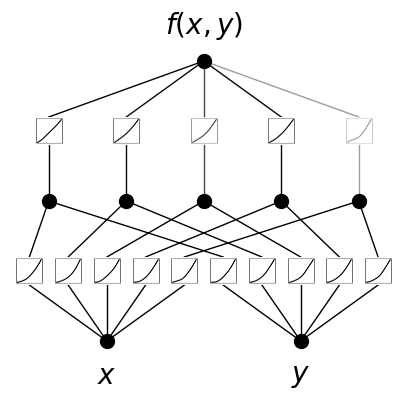

In [5]:
model(dataset['train_input']);
model.plot(beta=100, in_vars=['$x$', '$y$'], out_vars=['$f(x,y)$'])

Prima di tutto alleno il modello utilizzando la regolarizzazione L1, senza utilizzare l'entropia dei vari layer. In questo caso consideriamo la magnitudine della regolarizzazione $\lambda_1=0,01$.

In [6]:
model.train(dataset, opt="LBFGS", steps=50, lamb=0.01);

train loss: 4.28e-02 | test loss: 3.88e-02 | reg: 1.03e+01 : 100%|██| 50/50 [00:18<00:00,  2.65it/s]


Visualizziamo il modello allenato utilizzando la sola regolarizzazione L1 (anche se non lo specifichiamo, il parametro $\beta=3$ è di default).

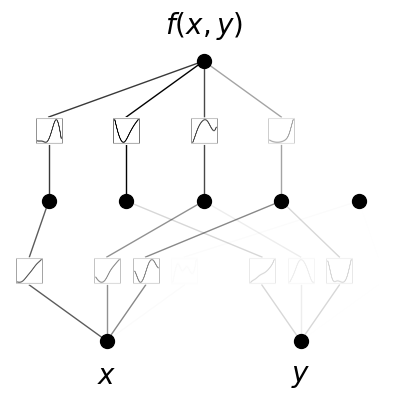

In [7]:
model.plot(beta=3, in_vars=['$x$', '$y$'], out_vars=['$f(x,y)$'])

Notiamo che i collegamenti ridondanti appaiono più trasparenti di quelli importanti. Per quanto riguarda i collegamenti rimasti, osserviamo la presenza di quelle che sembrerebbero le funzioni:
- $\phi^0_{3,2}=x^2$
- $\phi^1_{1,4}=e^x$

Effettuiamo dunque il pruning, definendo un nuovo modello 'model2' che andrà ad ereditare le caratteristichge del primo, ma si sbarazzerà delle funzioni di attivazioni (e quindi dei neuroni) ridondanti.

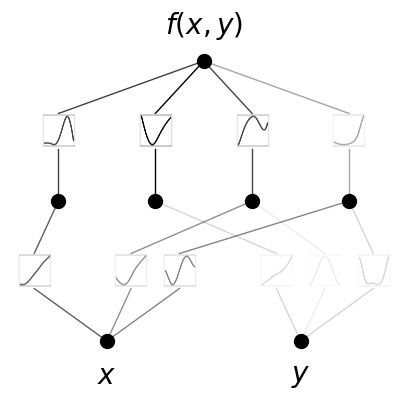

In [8]:
model2 = model.prune()
model2(dataset['train_input'])
model2.plot(beta=3, in_vars=['$x$', '$y$'], out_vars=['$f(x,y)$'])

Notiamo che il modello si è sicuramente alleggerito, tuttavia non si è arrivati al risultato sperato, ovvero avere un modello con le sole funzioni presenti in $f(x,y)$.

---

Vorremmo quindi ora semplificare ulteriormente il modello, attarverso sparsification e pruning, ottenendo però la KAN mostrata precedentemente, che restituisce quindi analiticamente la funzione $f(x,y)$.

Per fare ciò aggiungiamo alla regolarizzazione L1 mediante l'allenamento del modello, anche il calcolo dell'entropia di ogni layer. Quindi ridefiniamo il modello, e lo alleniamo utilizzando le magnitudini di regolarizzazione ed entropia $\lambda_1=0,01$ e $\lambda_2=1$. Dopo aver effettuato la sparsification del modello, effettuiamo il pruning.

In [9]:
model = KAN(width=[2,5,1], grid=5, k=3, seed=0)

In [10]:
model.train(dataset, opt="LBFGS", steps=50, lamb=0.01, lamb_entropy=1.0);

train loss: 4.32e-02 | test loss: 4.08e-02 | reg: 4.42e+00 : 100%|██| 50/50 [00:18<00:00,  2.75it/s]


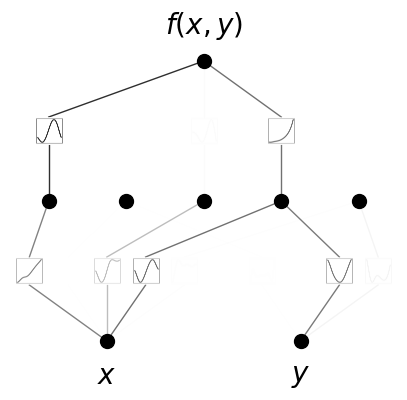

In [11]:
model.plot(beta=3, in_vars=['$x$', '$y$'], out_vars=['$f(x,y)$'])

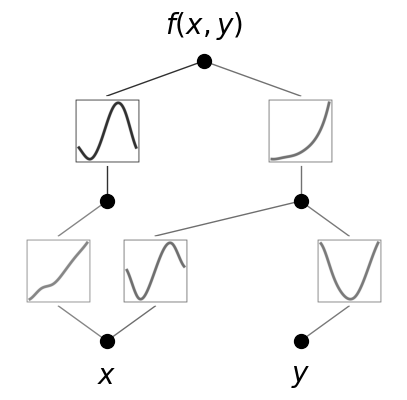

In [12]:
model2 = model.prune()
model2(dataset['train_input'])
model2.plot(beta=3, in_vars=['$x$', '$y$'], out_vars=['$f(x,y)$'])

Anche in questo caso non siamo riusciti ad ottenere la semplificazione che volevamo: ciò ci induce a pensare che bisogna aumentare la magnitudine dell'entropia, quando si effettua la sparsification.

Alleniamo il modello ora considerando le entropie della regolarizzazione e dell'entropia rispettivamente $\lambda_1=0,01$ e $\lambda_2=15$.

In [13]:
model = KAN(width=[2,5,1], grid=5, k=3, seed=0)

In [14]:
model.train(dataset, opt="LBFGS", steps=50, lamb=0.01, lamb_entropy=15.0);

train loss: 1.16e-01 | test loss: 1.19e-01 | reg: 3.36e+01 : 100%|██| 50/50 [00:18<00:00,  2.74it/s]


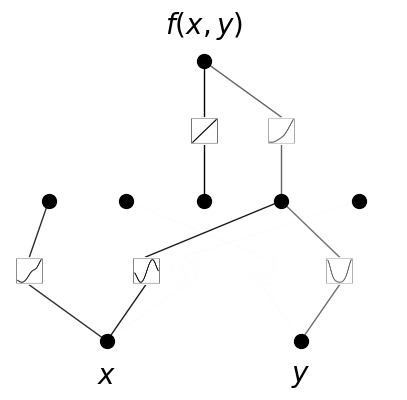

In [15]:
model.plot(beta=3, in_vars=['$x$', '$y$'], out_vars=['$f(x,y)$'])

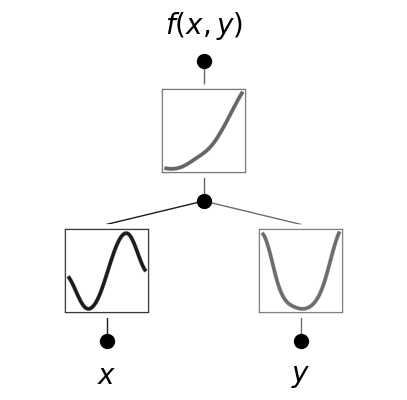

In [16]:
model2 = model.prune()
model2(dataset['train_input'])
model2.plot(beta=3, in_vars=['$x$', '$y$'], out_vars=['$f(x,y)$'])

Aggiustando le magnitudini della regolarizzazione e dell'entropia siamo riusciti ad ottenere la semplificazione che volevamo, dove le funzioni di attivazione nell'intervallo $[-1,1]$ sembrerebbero proprio quelle che compaiono nella funzione $f(x,y)$.

Per determinare se ciò è vero, possiamo effettuare un fit delle suddette funzioni attraverso il metodo $\texttt{auto\_symbolic}$, a cui possiamo passare un set di possibili funzioni, per cui esso restituirà la funzione più probabile $F$, fittando poi i parametri affini $a,b,c,d\in\mathbb{R}$, tali che $y\simeq cF(ax+b)+d$.

In [17]:
lib = ['x^2','x^4','exp','sin','tan','abs']
model2.auto_symbolic(lib=lib)
formula = model2.symbolic_formula()[0][0]
formula

fixing (0,0,0) with sin, r2=0.9975863099098206
fixing (0,1,0) with x^2, r2=0.9922897815704346
fixing (1,0,0) with x^4, r2=0.9985359907150269


0.71*(-0.37*x_2**2 - 0.36*sin(3.14*x_1 - 0.e-2) - 1)**4 + 0.21

Notiamo che tramite il metodo $\texttt{auto\_symbolic}$ non abbiamo ottenuto la funzione che ci aspettavamo, poichè l'esponenziale non è stato riconosciuto.

Vedremo se la funzione viene riconosciuta allenando il modello fin da subito con una KAN avente architettura $[2,1,1]$.

---

Determiniamo quindi ora se effettivamente la funzione
\begin{equation}
f(x,y)=\exp\Big(\sin(\pi x)+y^2\Big)\,\,\,,
\end{equation}
può essere fittata attravreso una KAN semplificata come in precedenza, ovvero attraverso una KAN senza hidden layers.

Se ciò avviene avremmo raggiunto un risultato importante: avremmo mostrato come una funzione $f(x,y)$ che tramite una MLP può essere fittata in modo efficace con una rete avente due hidden layer di 20 neuroni ciascuna, può essere fittata in modo altrettanto efficace attraverso una KAN avente solo due layer.

Ridefiniamo dunque il modello in modo che abbia due layer di funzioni di attivazione, un grid $G=5$, e un ordine polinomiale di B-spline $k=3$.

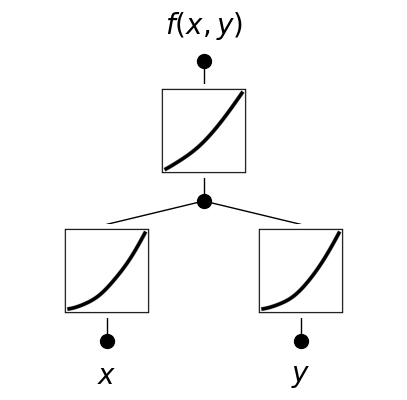

In [18]:
model = KAN(width=[2,1,1], grid=5, k=3, seed=0)
model(dataset['train_input']);
model.plot(beta=100, in_vars=['$x$', '$y$'], out_vars=['$f(x,y)$'])

In [19]:
results = model.train(dataset, opt="LBFGS", steps=50);

train loss: 1.17e-02 | test loss: 1.13e-02 | reg: 2.85e+00 : 100%|██| 50/50 [00:07<00:00,  7.01it/s]


Plotto ora l'andamento delle loss function di validation e di test, evidenziando il valore a cui arriva la loss di training.

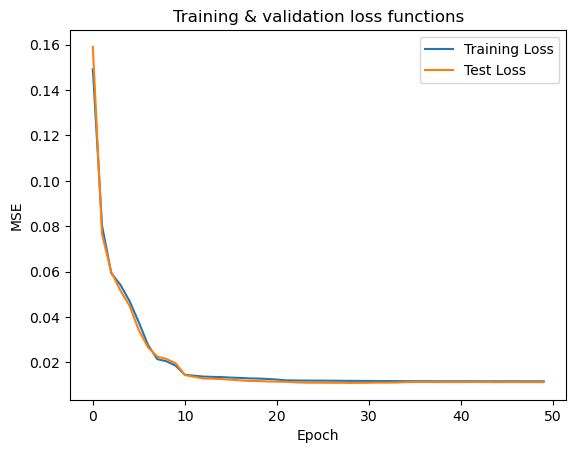

In [20]:
plt.figure()
plt.plot(results['train_loss'], label='Training Loss')
plt.plot(results['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training & validation loss functions')
plt.legend()
plt.show()

In [21]:
final_test_loss = results['test_loss'][-1]
print(f"Test Loss finale: {final_test_loss:.4f}")

Test Loss finale: 0.0113


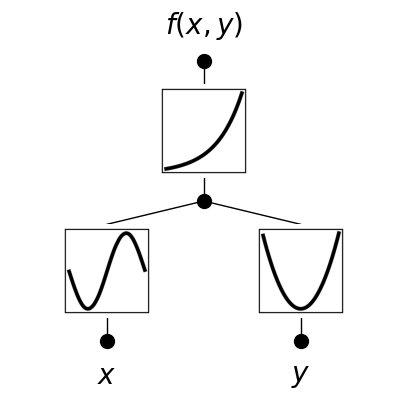

In [22]:
model.plot(beta=100, in_vars=['$x$', '$y$'], out_vars=['$f(x,y)$'])

Osserviamo che allenando fin da subito la KAN determinata dal modello soggetto a pruning, otteniamo comunque un ottimo fitting con un numero di parametri allenabili molto basso. Inoltre le funzioni di attivazione sembrerebbero proprio quelle che stavamo cercando di ottenere.

Passiamo un set di funzioni al metodo $\texttt{auto\_symbolic}$, verificando se la funzione che fitta la KAN in esame è proprio quella che volevamo ottenere.

In [23]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
formula

fixing (0,0,0) with sin, r2=0.999981701374054
fixing (0,1,0) with x^2, r2=0.9999997615814209
fixing (1,0,0) with exp, r2=0.9999995827674866


1.0*exp(1.0*x_2**2 + 1.0*sin(3.14*x_1))

Notiamo che allenando fin da subito la KAN che abbiamo ottenuto attraverso il pruning, ovvero quella con architettura $[2,1,1]$, otteniamo un ottimo fitting, pari a quello raggiunto dall'allenamento della KAN standard (vedi notebook precedente), e la funzione da fittare viene riconosciuta dalla suddetta KAN dopo l'allenamento.

Questo è un aspetto che ci fa rendere conto dell'interpretabilità delle Kolmogorov-Arnold NNetwork: attraverso una MLP si può risolvere un problema di regressione, ma a meno che la funzione da fittare non sia particolarmente semplice non si può ricavare analiticamente la funzione che fitta i dati. Attraverso una KAN è invece possibile ricavare analiticamente la funzione da fittare anche nei casi in cui è particolarmente complessa, ossevando direttamente le funzioni di attivazione generate dalla KAN stessa, e utilizzando il metodo $\texttt{auto\_symbolic}$.

---

Ora, abbiamo determinato che allenando una KAN con architettura semplificata si riesce ad ottenere un'ottimo fitting, paragonabile a quello che si ottiene allenando una KAN standard, ma con addirittura meno parametri allenabili. Questo è un altro punto a favore dell'utilizzo delle KAN rispetto all'utilizzo delle MLP per risolvere problemi di regressione: se è possibile effettuare un pruning della KAN, allora allenando quest'ultima si ottiene lo stesso bun fittin con un modello ancor più "snello".

Se si vuole raggiungere inoltre un livello di accuratezza ancora maggiore allenando il modello determinato dalla KAN con architettura $[2,1,1]$, è possibile aumentare la dimensione dei grid $G$, senza dover intaccare la profondità o l'ampiezza della rete: questo implica ottenere una maggior accuratezza senza aumentare a dismisura i parametri allenabili, come invece accade nelle MLP.

Determiniamo cosa accade nel allenare la KAN con architettura $[2,1,1]$ con un grid pari a $G=10$.

In [24]:
model = KAN(width=[2,1,1], grid=10, k=3, seed=0)
model.train(dataset, opt="LBFGS", steps=50);

train loss: 9.88e-03 | test loss: 9.80e-03 | reg: 2.68e+00 : 100%|██| 50/50 [00:07<00:00,  6.85it/s]


Osserviamo, come ci aspettavamo che le predizioni del modello sono migliorate rispetto a quello con un numero di grid $G=5$, essendo che la loss function di test a cui si arriva raggiunge addirittura un ordine di grandezza $L_{test}\sim 10^{-3}$

Discostiamoci adesso dai casi reali, e analizziamo l'addestramento delle KAN da un punto di vista prettamente teorico: consideriamo quindi dati generati senza errore gaussiano, senza incappare in overlearning determinato da questo tipo di errore.

Quello che faremo ora è ridefinire il modello determinato dalla KAN avente architettura $[2,1,1]$, inizialmente con $G=5$, e ogni 50 epoche di addestramento verrà aumentato il numero di grid, costruendo un nuovo modello che eredita i parametri del precedente allenamento, che verrà a sua volta allenato. In questo modo si può visualizzare come l'addestramento migliora aumentando la dimensione dei grid $G$.

Aumentando il numero di grid, i nuovi parametri $\{c_j'\}$ vengono inizializzati dagli $\{c_i\}$ minimizzando la distanza fra le spline vecchie e nuove:

\begin{equation}
\{c_j'\} = \arg\min_{\{c_j'\}}\mathbb{E}_{x\in p(x)}\bigg(\sum_{j=0}^{G_2}c_j'B_j'(x) - \sum_{i=0}^{G_1}c_iB_i(x)\bigg)^2\,\,\,,
\end{equation}

e possono essre implementati dall'algoritmo dei minimi quadrati.

In [25]:
set_seed(0)

x_train = np.random.uniform(-1, 1, 3000)
y_train = np.random.uniform(-1, 1, 3000)
training_label = np.exp(np.sin(np.pi*x_train) + y_train**2)

x_test = np.random.uniform(-1, 1, 200)
y_test = np.random.uniform(-1, 1, 200)
test_label = np.exp(np.sin(np.pi*x_test) + y_test**2)

# Combino x_train e y_train in un singolo array
training_data = np.column_stack((x_train, y_train))
test_data = np.column_stack((x_test, y_test))

# Converto i dati in tensori PyTorch
training_data = torch.tensor(training_data, dtype=torch.float32)
training_label = torch.tensor(training_label, dtype=torch.float32).view(-1, 1)
test_data = torch.tensor(test_data, dtype=torch.float32)
test_label = torch.tensor(test_label, dtype=torch.float32).view(-1, 1)

# Definisco il dizionario necessario per il training della KAN
dataset = {
    'train_input': training_data,
    'train_label': training_label,
    'test_input': test_data,
    'test_label': test_label
}

In [26]:
# Parametri di grid che andremo ad esaminare
# grids = np.array([5,10,20,50,100])
grids = np.array([5,10,15,20,25,30])

# Array in cui salviamo le loss di training e di test
train_losses = []
test_losses = []

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=3)
    if i != 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=3).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=50, stop_grid_update_step=30)
    train_losses += results['train_loss']
    test_losses += results['test_loss']

train loss: 6.27e-03 | test loss: 6.20e-03 | reg: 2.86e+00 : 100%|██| 50/50 [00:07<00:00,  6.62it/s]
train loss: 3.01e-04 | test loss: 2.68e-04 | reg: 2.86e+00 : 100%|██| 50/50 [00:05<00:00,  8.95it/s]
train loss: 5.81e-05 | test loss: 5.77e-05 | reg: 2.86e+00 : 100%|██| 50/50 [00:03<00:00, 12.75it/s]
train loss: 2.06e-05 | test loss: 1.98e-05 | reg: 2.86e+00 : 100%|██| 50/50 [00:04<00:00, 11.85it/s]
train loss: 1.30e-05 | test loss: 1.30e-05 | reg: 2.86e+00 : 100%|██| 50/50 [00:04<00:00, 11.47it/s]
train loss: 1.08e-05 | test loss: 1.03e-05 | reg: 2.86e+00 : 100%|██| 50/50 [00:04<00:00, 10.84it/s]


Possiamo già notare come la loss function di test diminuisca sensibilmente all'aumentare dei grid: plottiamo ora l'andamento delle loss function di training e test per verificare come queste evolvono con l'aumentare dei grid.

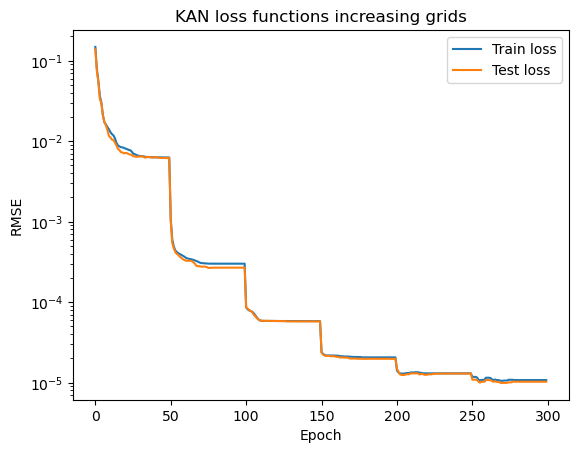

In [27]:
# Grafico delle loss in funzione delle epoche e dei grid (scala logaritmica)
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.title('KAN loss functions increasing grids')
plt.legend()
plt.yscale('log')
plt.savefig('loss_grids')
plt.show()

Dal grafico in scala logaritmica si può osservare come le loss function di training e di test sono soggette ad un crollo quando si aumenta il numero di grid. Addirittura, arrivando a 30 grid si raggiunge una loss di test con ordine di grandezza $L_{test}\sim 10^{-5}$: risultato molto difficile da ottenere con una MLP, anche utilizzando dati senza errore.

Ciò evidenzia l'eccezionale accuratezza che si può ottenere utilizzando le KAN, solo aumentando il numero di grid, senza quindi aumentare drasticamente il numero di parametri allenabili.

Nel prossimo notebook continueremo con l'analisi dell'accuratezza delle KAN a cui viene aumentato il numero di grid, studiando anche casi di overfitting.